<img src="Swisens_logo.png" width="240" height="240" align="left"/>
<div style="text-align: right">
    SwisensDataAnalyzer Introduction
    <br>Machine Learning Model Training
    <br>Author: <a href="mailto:yanick.zeder@swisens.ch">Yanick Zeder</a>
    <br> Copyright 2021, Swisens AG
    <br> <a href="mailto:yanick.zeder@swisens.ch"> Support </a>
</div>
Adapted and modified by MeteoSwiss.

# SwisensDataAnalyzer introduction - train ml models
This notebook is a short introduction on how to train a machine learning model on the data stored in a Swisens database.

## Prerequisites
The following modules must be installed in your python environment:
- `poleno_db_interface`
- `poleno_ml`

## Required knowledge
- How to use the SwisensDataExplorer (especially how to create and work with datasets)

## Known bugs
- Swisens' data loading code sometimes crashes with error "np.stack ValueError: need at least one array to stack". Seems to happen only when few datasets are loaded (e.g. when loading only the spores collection).
- EfficientNet suffers from a bug which makes it unable to be saved in TF2.10 ([source](https://discuss.tensorflow.org/t/using-efficientnetb0-and-save-model-will-result-unable-to-serialize-2-0896919-2-1128857-2-1081853-to-json-unrecognized-type-class-tensorflow-python-framework-ops-eagertensor/12518https://discuss.tensorflow.org/t/using-efficientnetb0-and-save-model-will-result-unable-to-serialize-2-0896919-2-1128857-2-1081853-to-json-unrecognized-type-class-tensorflow-python-framework-ops-eagertensor/12518)).

## Content

### Topics
This notebook takes you along the ride to train a ml model on datasets on the Swisens Database. First, we will see how we can set up a training pipeline. Afterwards, the pipeline is used to train a basic ML model. Then, we check the model on the test data and evaluate using a confusion matrix. Finally, we apply the model to a time series from a SwisensPoleno to evaluate the real-world performance of the model.

### Table of contents
1. [Add your DB credentials and connect](#query)
2. [Defining the datasets to use](#datasets)
3. [Setup the database connection and the dataset pipeline](#pipeline)
4. [Build the model](#model)
5. [Model evaluation](#evaluate)

### Imports

In [1]:
import os, sys
sys.path.append(
    "/tf/tmp/poleno-ml"
)
sys.path.append(
    "/tf/tmp/poleno-db-interface/"
)

In [2]:
# run this if you made changes to the poleno-ml code 
# NB: Those changes must have been made to the /tf/tmp/poleno-ml repository to have an effect on this notebook's code.
# NB: However, changes made to the tmp repository are temporary and will be rolled back when Docker VM will be shutdown.
#     If you want to make them permanent, dupplicate them to /tf/home/dependencies/poleno-ml.
!pip install /tf/tmp/poleno-ml

Processing /tf/tmp/poleno-ml
  Preparing metadata (setup.py) ... done
  Created wheel for poleno-ml: filename=poleno_ml-0.1.0-py3-none-any.whl size=16422 sha256=37dc4c771123c5f8dadd8435b0d1bec3d4b53442896aeb0646d1bd4dee06b5c1
  Stored in directory: /root/.cache/pip/wheels/36/27/94/c36c0ca182dfe6d14b2ad2190409db7ec462f251c1019d9266
Successfully built poleno-ml
  Attempting uninstall: poleno-ml
    Found existing installation: poleno-ml 0.1.0
    Uninstalling poleno-ml-0.1.0:
      Successfully uninstalled poleno-ml-0.1.0


In [3]:
# Import all other necessary modules
%load_ext autoreload
%autoreload 2
import cv2
import datetime
import io
import itertools
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import poleno_db_interface.database.model.data_explorer_model as dem
import poleno_db_interface.database.model.poleno_data_model as pdm
from poleno_ml.database.query_interface_ml import QueryInterfaceML, DatasetPipeline
import random
import sklearn.metrics
from sqlalchemy import func
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tqdm.notebook import tqdm
from typing import List
from uuid import UUID
import uuid

# allow memory growth
for dev in tf.config.list_physical_devices():
    try:
        tf.config.experimental.set_memory_growth(
            dev, True
        )
        print(f"Success for {dev}")
    except:
        print(f"Failed for {dev}")

# specifies which PhysicalDevice objects are visible to the runtime. TF will only allocate memory and place operations on visible physical devices
gpu0 = tf.config.list_physical_devices('GPU')[0] # use GPU 0
tf.config.set_visible_devices(gpu0, 'GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpu0, 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=25_000)] # set max GPU memory usage
)

Failed for PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Success for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Success for PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Establishing a database connection <a class="anchor" id="query"></a>

In [4]:
import myloginpath
db_config = myloginpath.parse('client', path='/tf/.mylogin.cnf')

# Conect to the database and create an interface instance
query_interface_ml = QueryInterfaceML(**db_config)

### Defining the datasets and parameters to use <a class="anchor" id="datasets"></a>
    
<b>ATTENTION: If you change the values in here, make sure you delete all dataset cache files. These are called 'train_cache*' or 'test_cache*' and are located at the same location as this notebook. If you do not delete these caches, the training will run on the old dataset definition!!</b>

In [5]:
# A dictionary that has the form of { <collection>: { <dataset-id>: <class-label> } }
# Collection name can be choosen freely and is intended to enable grouping of datasets into logical
# units independnet on class. Typically, this can be used to seperate datasets form different systems
# but can also be used to separate different years, sample source or any other propertie. Later in the
# notebook, you will then be able to create test and validation sets with different collections as
# source.
DATASET_DEFINITIONS = {
    
    "raw-pollens": {
        "11ea8493-7107-8db4-9bf7-ae7b87f820b4": "Alnus",
        "11ea847a-f995-790c-830f-ae7b87f820b4": "Alnus",
        "11ea8475-957e-347c-985a-ae7b87f820b4": "Alnus",
        "11ea8897-f50e-66a2-9876-ae7b87f820b4": "Betula",
        "11ea8632-18ed-7210-985a-ae7b87f820b4": "Betula",
        "11ea8632-1eb2-2452-bc84-ae7b87f820b4": "Betula",
        "11ea8f77-4ee3-aef4-b330-ae7b87f820b4": "Carpinus",
        "11ea8f6d-3e75-9fe6-b46e-ae7b87f820b4": "Carpinus",
        "11ea8f6d-1562-211a-8192-ae7b87f820b4": "Carpinus",
        "11ea8f6c-b78c-d076-a542-ae7b87f820b4": "Carpinus",
        "11ea8498-b729-d4e6-bc84-ae7b87f820b4": "Corylus",
        "11ea8498-b083-cb92-a1a5-ae7b87f820b4": "Corylus",
        "11ea8498-afa9-cec4-a877-ae7b87f820b4": "Corylus",
        "11ea8fa9-6c12-723a-b3dd-ae7b87f820b4": "Cupressus",
        "11ea8fa8-fafa-aeb4-ac46-ae7b87f820b4": "Cupressus",
        "11ea8fa8-d163-dce2-b1cb-ae7b87f820b4": "Cupressus",
        "11ea8636-313b-a6e4-a69e-ae7b87f820b4": "Fagus",
        "11ea8635-ef91-6ab2-a877-ae7b87f820b4": "Fagus",
        "11ea8635-eb18-6ee0-9876-ae7b87f820b4": "Fagus",
        "11ea857e-7bc5-60a0-842e-ae7b87f820b4": "Fraxinus",
        "11ea857b-3d52-9034-830f-ae7b87f820b4": "Fraxinus",
        "11ea857b-150e-c372-bc84-ae7b87f820b4": "Fraxinus",
        "11ea8af3-c533-f39e-8b25-ae7b87f820b4": "Pinaceae",
        "11ea8af1-91fc-9a46-8b25-ae7b87f820b4": "Pinaceae",
        "11ea8af0-83dc-6d66-b06c-ae7b87f820b4": "Pinaceae",
        "11ea863d-acf6-0ade-985a-ae7b87f820b4": "Pinaceae",
        "11ea863c-2449-be52-8814-ae7b87f820b4": "Pinaceae",
        "11ea8b83-25c9-8194-90d1-ae7b87f820b4": "Platanus",
        "11ea8881-3721-9aa8-a907-ae7b87f820b4": "Platanus",
        "11ea990f-ee01-8334-b3dd-ae7b87f820b4": "Poaceae",
        "11ea990c-b2bc-fe96-b46e-ae7b87f820b4": "Poaceae",
        "11eb5fd9-961a-313e-ac56-ae7b87f820b4": "Poaceae",
        "11eb5fd9-dd36-0a20-88f3-ae7b87f820b4": "Poaceae",
        "11ebe542-660e-0206-80be-ae7b87f820b4": "Poaceae",
        "11eb5fc3-03fa-6da2-8b42-ae7b87f820b4": "Poaceae",
        "11ebe540-187e-9a0c-b0e2-ae7b87f820b4": "Poaceae",
        "11ea8893-edfb-ca84-a877-ae7b87f820b4": "Populus",
        "11ea84a0-e89b-43b8-a69e-ae7b87f820b4": "Populus",
        "11ea84a0-a2f0-ab8c-a877-ae7b87f820b4": "Populus",
        "11ea863e-1fea-0f7c-a1a5-ae7b87f820b4": "Quercus",
        "11ea863e-1b86-8226-a1a5-ae7b87f820b4": "Quercus",
        "11ea863d-f388-a038-a1a5-ae7b87f820b4": "Quercus",
        "11ea8477-cede-e7dc-897d-ae7b87f820b4": "Taxus",
        "11ea8477-b584-b690-830f-ae7b87f820b4": "Taxus",
        "11ea8494-33a5-2e4e-bc84-ae7b87f820b4": "Taxus",
        "11ea849c-df8f-d95e-897d-ae7b87f820b4": "Ulmus",
        "11ea849c-db7b-2170-8b0f-ae7b87f820b4": "Ulmus",
        "11ea849a-0e25-4018-8814-ae7b87f820b4": "Ulmus",
    },
    
    "old-pollens": {
        "11ea5df1-de4e-68a2-bdea-ae7b87f820b4": "Alnus",
        "11ea5dec-aad2-40f2-adc5-ae7b87f820b4": "Alnus",
        "11ea5dea-76dd-45e6-9881-ae7b87f820b4": "Alnus",
        "11ea8318-8f19-8414-8f2c-ae7b87f820b4": "Betula",
        "11ea831d-c087-d5fa-8016-ae7b87f820b4": "Betula",
        "11ea8319-0f9b-2f84-8f2c-ae7b87f820b4": "Betula",
        "11ea74ee-1ae2-3f42-bdc8-ae7b87f820b4": "Carpinus",
        "11ea74ef-1f33-22e0-b530-ae7b87f820b4": "Carpinus",
        "11ea74ef-7256-f794-8624-ae7b87f820b4": "Carpinus",
        "11ea74ef-cf63-afc2-bdc8-ae7b87f820b4": "Carpinus",
        "11ea5e04-fc94-364e-81ab-ae7b87f820b4": "Corylus",
        "11ea5e04-ae5b-1ace-9881-ae7b87f820b4": "Corylus",
        "11ea5e00-93c5-6f88-81ab-ae7b87f820b4": "Corylus",
        "11ea74e8-0f90-f08a-9ea9-ae7b87f820b4": "Cupressus",
        "11ea74ea-1a2b-69ec-9846-ae7b87f820b4": "Cupressus",
        "11ea74ea-93f3-4862-bc81-ae7b87f820b4": "Cupressus",
        "11ea831e-9169-688c-9d84-ae7b87f820b4": "Fagus",
        "11ea831e-5779-4480-a7e8-ae7b87f820b4": "Fagus",
        "11ea831e-0698-1618-8016-ae7b87f820b4": "Fagus",
        "11ea8314-3a9a-8644-8fc4-ae7b87f820b4": "Fraxinus",
        "11ea8313-8fef-2358-8016-ae7b87f820b4": "Fraxinus",
        "11ea8313-1742-26b2-9d84-ae7b87f820b4": "Fraxinus",
        "11ea8af1-16b3-afbe-b419-ae7b87f820b4": "Pinaceae", # Picea
        "11ea8af1-8668-a68e-b06c-ae7b87f820b4": "Pinaceae", # Picea
        "11ea8af0-7bba-7a4c-9b82-ae7b87f820b4": "Pinaceae", # Picea
        "11ea863b-0dbc-a204-8b0f-ae7b87f820b4": "Pinaceae", # Pinus
        "11ea863c-0128-16ee-a69e-ae7b87f820b4": "Pinaceae", # Pinus
        "11ea831f-8774-33e2-b44c-ae7b87f820b4": "Plantanus",
        "11ea831f-3746-b084-a59a-ae7b87f820b4": "Plantanus",
        "11ea990d-99b7-329e-b330-ae7b87f820b4": "Poaceae",
        "11ea990c-a115-87c6-b46e-ae7b87f820b4": "Poaceae",
        "11ea9a91-09a7-100e-86f2-ae7b87f820b4": "Poaceae", # Cynosurus
        "11ea9a73-0d84-81ca-b3dd-ae7b87f820b4": "Poaceae", # Cynosurus
        "11ebde5f-23d5-5e8c-8d93-ae7b87f820b4": "Poaceae", # Dactylis
        "11ea9911-17a1-65b4-89a8-ae7b87f820b4": "Poaceae", # Dactylis
        "11ebde60-40fb-4aa2-a536-ae7b87f820b4": "Poaceae", # Trisetum
        "11ea830f-df57-8bdc-91a3-ae7b87f820b4": "Populus",
        "11ea74e3-b2e6-df38-b530-ae7b87f820b4": "Populus",
        "11ea74e4-5089-a266-8624-ae7b87f820b4": "Populus",
        "11ea863a-bdae-8df4-a69e-ae7b87f820b4": "Quercus",
        "11ea863a-2252-7b54-a1a5-ae7b87f820b4": "Quercus",
        "11ea8639-acca-ee52-aa3e-ae7b87f820b4": "Quercus",
        "11ea5deb-b5f0-b38e-9881-ae7b87f820b4": "Taxus",
        "11ea5deb-6fa4-5f7a-bd51-ae7b87f820b4": "Taxus",
        "11ea5df3-6b53-0252-adc5-ae7b87f820b4": "Taxus",
        "11ea74d0-dd4c-4d34-9ea9-ae7b87f820b4": "Ulmus",
        "11ea74cf-fc64-b108-8624-ae7b87f820b4": "Ulmus",
        "11ea5ef1-f146-eabe-ab02-ae7b87f820b4": "Ulmus",
    },
    
    "new-pollens": { # same datasets as in "old-pollens" but cleaned using a different strategy
        "11ed3b18-1ba8-ee6a-a8d4-496190c661df": "Alnus",
        "11ed3821-9ab6-8dba-a8d4-496190c661df": "Alnus",
        "11ed382b-542a-0dea-a8d4-496190c661df": "Alnus",
        "11ed3832-b506-668e-a8d4-496190c661df": "Betula",
        "11ed3a58-07b4-deb6-a8d4-496190c661df": "Betula",
        "11ed38e1-b2f4-f996-a8d4-496190c661df": "Betula",
        "11ed5ea4-96ed-bdf8-acbd-a95f70cb44b0": "Carpinus",
        "11ed5f80-5dcc-9c24-acbd-a95f70cb44b0": "Carpinus",
        "11ed3a6b-5612-556c-a8d4-496190c661df": "Carpinus",
        "11ed3982-4837-efd6-a8d4-496190c661df": "Carpinus",
        "11ed38e0-6bee-47ec-a8d4-496190c661df": "Corylus",
        "11ed3a6f-f2ce-f140-a8d4-496190c661df": "Corylus",
        "11ed431c-682d-5986-a8d4-496190c661df": "Corylus",
        "11ed38ea-0973-6246-a8d4-496190c661df": "Cupressus",
        "11ed3a79-1b42-92c2-a8d4-496190c661df": "Cupressus",
        "11ed431e-c1e0-39ce-a8d4-496190c661df": "Cupressus",
        "11ed3a7c-3218-626c-a8d4-496190c661df": "Fagus",
        "11ed5f45-7fe1-e688-acbd-a95f70cb44b0": "Fagus",
        "11ed5f7b-c645-a4b2-acbd-a95f70cb44b0": "Fagus",
        "11ed3b22-8577-b13c-a8d4-496190c661df": "Fraxinus",
        "11ed5f4a-52c3-34a4-acbd-a95f70cb44b0": "Fraxinus",
        "11ed5f7e-c6f1-7f46-acbd-a95f70cb44b0": "Fraxinus",
        "11ed3d7f-b12e-ad76-a8d4-496190c661df": "Pinaceae", # Picea
        "11ed5f4d-49d0-5748-acbd-a95f70cb44b0": "Pinaceae", # Picea
        "11ed5f82-2199-44da-acbd-a95f70cb44b0": "Pinaceae", # Picea
        "11ed3d9b-7037-b6fc-a8d4-496190c661df": "Pinaceae", # Pinus
        "11ed5494-ad56-7e64-acbd-a95f70cb44b0": "Pinaceae", # Pinus
        "11ed5535-c71d-065a-acbd-a95f70cb44b0": "Pinaceae", # Pinus
        "11ed55ce-5aaf-a2ae-acbd-a95f70cb44b0": "Pinaceae", # Pinus
        "11ed55d0-cec8-bdae-acbd-a95f70cb44b0": "Pinaceae", # Pinus
        "11ed55d5-a393-64c2-acbd-a95f70cb44b0": "Pinaceae", # Pinus
        "11ed5907-4d09-f0b4-acbd-a95f70cb44b0": "Plantanus",
        "11ed6006-a52a-2448-acbd-a95f70cb44b0": "Plantanus",
        "11ed43d2-4043-b620-a8d4-496190c661df": "Poaceae",
        "11ed6009-3e1d-3184-acbd-a95f70cb44b0": "Poaceae",
        "11ed6030-3f50-655e-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed6035-488e-4564-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed6037-d194-cad4-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed6039-e772-8574-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed591a-064b-e868-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed591c-0732-bf5c-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed5922-9f70-fc56-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed5925-0949-93b6-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed5926-9845-1346-acbd-a95f70cb44b0": "Poaceae", # Cynosurus
        "11ed6032-1974-ee34-acbd-a95f70cb44b0": "Poaceae", # Dactylis
        "11ed6036-c877-51c0-acbd-a95f70cb44b0": "Poaceae", # Dactylis
        "11ed603b-8b16-bcf8-acbd-a95f70cb44b0": "Poaceae", # Dactylis
        "11ed6038-9eb8-c42a-acbd-a95f70cb44b0": "Poaceae", # Dactylis
        "11ed6010-ad76-a770-acbd-a95f70cb44b0": "Poaceae", # Dactylis
        "11ed4487-97ec-87e8-a8d4-496190c661df": "Poaceae", # Trisetum
        "11ed5928-4b40-315a-acbd-a95f70cb44b0": "Populus",
        "11ed6012-cffe-1c4a-acbd-a95f70cb44b0": "Populus",
        "11ed6041-5f45-1876-acbd-a95f70cb44b0": "Populus",
        "11ed5930-a266-322e-acbd-a95f70cb44b0": "Quercus",
        "11ed601d-4f24-ca46-acbd-a95f70cb44b0": "Quercus",
        "11ed6045-38bd-92ec-acbd-a95f70cb44b0": "Quercus",
        "11ed59c8-6d52-bbaa-acbd-a95f70cb44b0": "Taxus",
        "11ed602a-3932-49e0-acbd-a95f70cb44b0": "Taxus",
        "11ed604c-7275-f1b2-acbd-a95f70cb44b0": "Taxus",
        "11ed59ca-df2c-2188-acbd-a95f70cb44b0": "Ulmus",
        "11ed602d-6874-225c-acbd-a95f70cb44b0": "Ulmus",
        "11ed6048-9fb9-4b28-acbd-a95f70cb44b0": "Ulmus",
    },
    
    "other": {
        "11ed65b6-6a22-1968-b56b-ae7b87f820b4": "Artemisia",
        "11ed463e-f09f-6456-b550-ae7b87f820b4": "Cedrus",
        "11ec6179-fde0-042c-adac-ae7b87f820b4": "Iberulites",
        "11ec617a-fb8b-e3f2-80fb-ae7b87f820b4": "Iberulites",
        "11ec5821-b371-c3dc-8359-ae7b87f820b4": "Iberulites",
        "11ec5832-4fee-03b4-8561-ae7b87f820b4": "Iberulites",
        "11ebe542-f782-c172-bf10-ae7b87f820b4": "Waterdroplets",
        "11ebeabd-e224-d5c4-8b63-ae7b87f820b4": "Waterdroplets",
        "11ebedec-0da5-47ac-8066-ae7b87f820b4": "Waterdroplets",
        "11ebee15-1fea-4c68-9cd6-ae7b87f820b4": "Waterdroplets",
    },
    
    "spores": {
        "11ebf9db-f2e9-98cc-bc67-ae7b87f820b4": "Alternaria Solani",
        "11ec01b9-d571-ea8e-b7e1-ae7b87f820b4": "Fusarium Graminearum",
    },
}

In [6]:
model_name = 'real1'
model_path = 'models'

In [7]:
batch_size = 8 # Can typically be left as is. Depending on your hardware you can try to increase the value to get better performance.
epochs = 256
img_shape = (200,200,1)
model_features = [
     'rec0', 'rec1'  
] #Can typically be left as is. This defines on what data we want to train. Usually, we train on the two images 'rec0' and 'rec1'
data_filters = [
    #'blur', # remove blurry events
    #'crop', # remove cropped events
]
data_maps = [
    #'process_waves', # remove "waves" from all events
    'holo_aug', # image augmentation
]
caching = True

collections_train = [
    #"raw-pollens",
    #"old-pollens",
    "new-pollens",
    "other",
    "spores",
]

# These two values only apply when collections_val is empty
train_part = 0.7
test_part = 0.3

# Leave empty if you'd like to train and eval on the same collections
collections_val = []

classes = set(cls 
              for collection in collections_train + collections_val 
              for cls in DATASET_DEFINITIONS[collection].values())

In [8]:
os.makedirs(os.path.join(model_path, model_name, "training"), exist_ok=True)
os.makedirs(os.path.join(model_path, model_name, "model"), exist_ok=True)
ds_train_cache_path = os.path.join(model_path, model_name, 'training', f'train_cache_{"_".join(collections_train)}{"_" + "_".join(data_filters + data_maps) if len(data_filters + data_maps) > 0 else ""}')
if len(collections_val) == 0:
    cache_name = f'test_cache_{"_".join(collections_train)}'
else:
    cache_name = f'test_cache_{"_".join(collections_val)}'
ds_val_cache_path = os.path.join(model_path, model_name, 'training', f'{cache_name}{"_" + "_".join(data_filters + data_maps) if len(data_filters + data_maps) > 0 else ""}')
model_timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_file_path = os.path.join(model_path, model_name, 'training', 'checkpoints', model_timestamp)
model_file_path = os.path.join(model_path, model_name, 'model')
model_info_file_path = os.path.join(model_path, model_name, 'model', 'model_info.json')
logdir = os.path.join(model_path, model_name, 'training', 'logs', model_timestamp)
os.makedirs(logdir, exist_ok=True)

In [9]:
# model's info to save on disk
model_info = {
    'model_name': model_name,
    'model_timestamp': model_timestamp,
    'batch_size': batch_size,
    'model_features': model_features,
    'data_filters': data_filters,
    'data_maps': data_maps,
    'collections_train': collections_train,
    'train_part': train_part,
    'test_part': test_part,
    'collections_val': collections_val,
    'classes': list(classes),
    'DATASET_DEFINITIONS': DATASET_DEFINITIONS,
}

### Computed Values
Here we define the class weights for unbalanced datasets, the class counts, the class labels and we compute the model name.

First, we define some helper functions:

In [10]:
def get_dataset_mapping(ds_map: dict, collections: List[str], classes: List[str]):
    """This method filters a dataset definition for specific systems and class labels
    and returns a flat dictionary with { <dataset-id>: <class-label> } """
    
    ret = {}
    for c in collections:
        ret.update(
            { key: value for key, value in ds_map[c].items() if value in classes}
        )
    return ret

def get_dataset_sizes(ds_map_flat: dict):
    """Return a dict with <dataset-id>: <class-size>"""
    
    dataset_sizes = {}
    for k, v in dataset_map.items():
        result = query_interface_ml.session.query(
            func.count(dem.EventsInEventDataset.event_id)
        ).filter(
            dem.EventsInEventDataset.dataset_id==uuid.UUID(k).bytes
        ).all()
        dataset_sizes[k] = result[0][0]
    return dataset_sizes
    
def get_class_sizes(ds_map_flat: dict, dataset_sizes: dict):
    """Return a dict with <class-name>: <class-size>"""
    
    class_sizes = {}
    for k, v in dataset_map.items():
        size = dataset_sizes[k]
        if v not in class_sizes: class_sizes[v] = 0
        class_sizes[v] += size
    return class_sizes

def get_sorted_class_list(ds_map_flat: dict):
    return sorted(list(set(ds_map_flat.values())))

... and then we can compute the values

In [11]:
# Get the dataset collection you need for the training
dataset_map = get_dataset_mapping(
    DATASET_DEFINITIONS,
    collections=collections_train,
    classes=classes
)
assert len(dataset_map) > 0

dataset_sizes = get_dataset_sizes(dataset_map)
class_sizes = get_class_sizes(dataset_map, dataset_sizes)
classes = get_sorted_class_list(dataset_map)
num_classes = len(classes)

n_samples = sum(dataset_sizes.values())
class_counts = [class_sizes[d] for d in classes]
class_weights = n_samples / np.array(class_counts)
model_info['class_weights'] = list(class_weights)

### Setup the dataset pipeline <a class="anchor" id="pipeline"></a>
This step builds the dataset pipeline used later to train the model. Here we have to make the decision if we would like to validate on a part of the training dataset, or if we would like to define a seperate set of datasets for validation.

If we use the same datasets for training as for validation, we have to define in what portions we would like to split the data into. Typically, we use 80% to 20% split.

#### Load train and validation sets

In [12]:
if len(collections_val) == 0:

    dataset_train, dataset_val = query_interface_ml.prepare_tf_dataset_from_poleno_datasets(
        dataset_list=list(dataset_map.keys()),
        batch_size=batch_size,
        model_features=model_features,
        labels=classes,
        dataset_label_mapping=dataset_map,
        split=(train_part, test_part)
    )

else:
    
    dataset_map_val = get_dataset_mapping(
        DATASET_DEFINITIONS,
        collections=collections_val,
        classes=classes
    )
    
    dataset_train = query_interface_ml.prepare_tf_dataset_from_poleno_datasets(
        dataset_list=list(dataset_map.keys()),
        batch_size=batch_size,
        model_features=model_features,
        labels=classes,
        dataset_label_mapping=dataset_map,
    )
    
    dataset_val = query_interface_ml.prepare_tf_dataset_from_poleno_datasets(
        dataset_list=list(dataset_map_val.keys()),
        batch_size=batch_size,
        model_features=model_features,
        labels=classes,
        dataset_label_mapping=dataset_map_val,
    )
    

#### Define then apply filters and maps (e.g. data augmentation)

In [13]:
# define data filters
# filters out images where particles are cropped
def filter_crop(rec0: tf.Tensor, rec1: tf.Tensor, T: float = .0001, BT: float = .85):
    border = [0,rec0.shape[0]-1]
    mask = np.array([
        [1. if i in border or j in border else 0. for j in range(rec0.shape[1])]
        for i in range(rec0.shape[0])
    ]).reshape(*rec0.shape)
    apply_filter_crop_ = lambda x: ((x.numpy()<BT)*mask).sum() / mask.sum() > T # return True if particle is cropped
    return not apply_filter_crop_(rec0) and not apply_filter_crop_(rec1)
apply_filter_crop = lambda ids, features, targets: tf.py_function( #py_function to work in eager mode (dataset operations are in graph mode by default)
    filter_crop, [features['rec0'], features['rec1']], Tout=tf.bool
)

# filters out images where particles are blurry
def filter_blur(rec0: tf.Tensor, rec1: tf.Tensor, T: float = .0014):
    apply_filter_blur_ = lambda x: cv2.Laplacian(x.numpy(), cv2.CV_32F).var() < T # return True if image is blurred
    return not apply_filter_blur_(rec0) and not apply_filter_blur_(rec1)
apply_filter_blur = lambda ids, features, targets: tf.py_function( #py_function to work in eager mode (dataset operations are in graph mode by default)
    filter_blur, [features['rec0'], features['rec1']], Tout=tf.bool
)

def filter_test(rec0: tf.Tensor, rec1: tf.Tensor):
    apply_filter_test_ = lambda x: True
    return not apply_filter_test_(rec0) and not apply_filter_test_(rec1)
apply_filter_test = lambda ids, features, targets: tf.py_function( #py_function to work in eager mode (dataset operations are in graph mode by default)
    filter_test, [features['rec0'], features['rec1']], Tout=tf.bool
)

In [14]:
# define data maps:
# removes "waves" around the particles
def rmv_waves(rec: tf.Tensor):
    img = (rec.numpy()*255).astype(np.uint8)
    img = img.reshape(*img.shape[:-1])
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cleaned = img * ~(mask).astype(bool)
    return cleaned

# performs random image augmentation
upper = 120 * (math.pi/180.0) # degrees -> radian
lower = -120 * (math.pi/180.0)
def rand_degree():
    return random.uniform(lower, upper)
def augment_using_ops(img: tf.Tensor):
    try: img = tf.image.random_flip_left_right(img)
    except: print("flip hori")
    try: img = tf.image.random_flip_up_down(img)
    except: print("flip vert")
    try: img = tf.image.random_brightness(img, 0.1)
    except: print("brightness")
    try: img = tf.image.random_contrast(img, 0.7, 1.3)
    except: print("contrast")
    try: img = tfa.image.rotate(img, rand_degree(), fill_mode='nearest') # fill_mode='constant', fill_value=1.
    except: print("rotate")
    return img

In [15]:
def apply_custom_holo_map(func, *args):
    func_ = lambda x: tf.reshape(
        tf.convert_to_tensor(
            tf.py_function(func, [x], Tout=[tf.float32]), 
            dtype=tf.float32),
        img_shape)
    args[1]['rec0'] = func_(args[1]['rec0'])
    args[1]['rec1'] = func_(args[1]['rec1'])
    return args

In [16]:
# apply data filters and data maps
dataset_train.tf_dataset = dataset_train.tf_dataset.unbatch()
dataset_val.tf_dataset = dataset_val.tf_dataset.unbatch()

if 'blur' in data_filters:
    dataset_train.tf_dataset = dataset_train.tf_dataset.filter(apply_filter_blur)
    dataset_val.tf_dataset = dataset_val.tf_dataset.filter(apply_filter_blur)
if 'crop' in data_filters:
    dataset_train.tf_dataset = dataset_train.tf_dataset.filter(apply_filter_crop)
    dataset_val.tf_dataset = dataset_val.tf_dataset.filter(apply_filter_crop)
if 'process_waves' in data_maps:
    dataset_train.tf_dataset = dataset_train.tf_dataset.map(lambda *args: apply_custom_holo_map(rmv_waves, *args), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    dataset_val.tf_dataset = dataset_val.tf_dataset.map(lambda *args: apply_custom_holo_map(rmv_waves, *args), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
if 'holo_aug' in data_maps:
    augmented_train = dataset_train.tf_dataset.map(lambda *args: apply_custom_holo_map(augment_using_ops, *args), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    dataset_train.tf_dataset = dataset_train.tf_dataset.concatenate(augmented_train)

#### Cache, shuffle, batch, and prefetch

In [17]:
# Cache the pipeline to a file in order to make subsequent training passes much faster
if caching:
    # Cache the pipeline to a file in order to make subsequent training passes much faster
    dataset_train.enable_cache(ds_train_cache_path, prepare=True)

ATTENTION: Remember to remove the cache file if you make changes to the dataset! Otherwise, the changes will not be reflected into the dataset and the trainingwill run on the old data.


Preparing cache:   0%|          | 0/146672 [00:00<?, ?it/s]

Caching is done.


In [18]:
if caching:
    dataset_val.enable_cache(ds_val_cache_path, prepare=True)

ATTENTION: Remember to remove the cache file if you make changes to the dataset! Otherwise, the changes will not be reflected into the dataset and the trainingwill run on the old data.


Preparing cache:   0%|          | 0/62864 [00:00<?, ?it/s]

Caching is done.


In [19]:
dataset_train.tf_dataset = dataset_train.tf_dataset.shuffle(batch_size*100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset_val.tf_dataset = dataset_val.tf_dataset.shuffle(batch_size*100, reshuffle_each_iteration=False).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
print(f"dataset lengths: (train: {dataset_train.dataset_length}, val: {dataset_val.dataset_length})")
print(f"number of classes: (train: {dataset_train.num_classes}, val: {dataset_val.num_classes})")

dataset lengths: (train: 146672, val: 62864)
number of classes: (train: 20, val: 20)


### Build the model <a class="anchor" id="model"></a>
Now we can build the model we want to train. You can use any model you can imagine as long as the model has:
- two inputs with the shape 200x200x1 with the names 'rec0' and 'rec1'
- an output layer with the name 'target' and a dimension of #classes

#### Pre-trained EffNet
This uses transferlearning in order to get fast results. You can choose between 8 models B0 - B7, each a little larger than the previous. The way this is set up is that we remove the final layer of the pretrained network and add our own output layer corresponding to our classes.

Note that in our testing, B0 is sufficient for most applications. With larger models you increase the tendency to overfit the data. If you have many classes and large datasets, you can consider increasing the model size.

In [21]:
# WARNING: THIS IS NOT A GOOD IDEA TO DO IF YOU DOWNLOAD DATA FROM UNKNOW OR UNVERIFIED SOURCES !!!
# THIS COULD INDUCE HUGE SECURITY RISKS.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
inputs = []
paths = []

if "rec0" in model_features and "rec1" in model_features:
    input0 = keras.layers.Input(shape=[200,200,1], name="rec0")
    inputs.append(input0)
    input1 = keras.layers.Input(shape=[200,200,1], name="rec1")
    inputs.append(input1)

    input0_reshape = keras.layers.Concatenate()([input0,input0,input0])
    input1_reshape = keras.layers.Concatenate()([input1,input1,input1])
    input0_reshape = input0_reshape * 255 # effnet expects [0, 255] data range
    input1_reshape = input1_reshape * 255 # effnet expects [0, 255] data range

    ###                                   -> VVVV <- Change here to B0 - B7 if needed.
    effnetB0 = keras.applications.EfficientNetB0(input_shape=(200,200,3), 
                                                 drop_connect_rate=0.4, # extra regularization in finetuning, but does not affect loaded weights
                                                 include_top=False, weights='imagenet')
    effnetB0.trainable = False

    path0 = effnetB0(input0_reshape)
    path1 = effnetB0(input1_reshape)

    holo_path_ = keras.layers.Concatenate()([path0, path1])
    holo_path_ = keras.layers.Flatten()(holo_path_)
    
    paths.append(holo_path_)

if "fl_spectra" in model_features:
    input_fl = keras.layers.Input(shape=[13], name="fl_spectra")
    fl_path = input_fl * 255
    fl_path = keras.layers.Dense(255)(fl_path)
    inputs.append(input_fl)
    paths.append(fl_path)

if len(paths) > 1:
    path_ = keras.layers.Concatenate()(paths)
else:
    path_ = paths[0]

path_ = keras.layers.Dropout(.4)(path_)
outputs = keras.layers.Dense(
    num_classes,
    activation="sigmoid",
    name="target"
)(path_)
#outputs = keras.layers.Softmax(name="target")(outputs)


model = keras.Model(inputs=inputs, outputs=[outputs])

"done"

'done'

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rec0 (InputLayer)              [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 rec1 (InputLayer)              [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 200, 200, 3)  0           ['rec0[0][0]',                   
                                                                  'rec0[0][0]',               

### Compile the model
By compiling we are adding the optimizer function and the loss function which drive the actual training. Usually, this can be left as is.

If you notice that the model trains very slowly -> increase learning_rate <br>
If the loss is fluctuating or rising -> decrease learning_rate

In [42]:
# To compile the model, we need a special loss funtion that allows for class weights. The details are not that important. Relavent to know
# is that this allows for inbalanced data to be trained correctly. For example, if you have two times more of class 1 than in class 2, then
# you would like the model to ignore this difference and act as if the two sets are identical in size.

class WeightedSCCE(tf.keras.losses.Loss):
    """Custom SparseCategoricalCrossentropy loss class that supports class weights."""
    def __init__(self, class_weight, from_logits=False, name='weighted_scce'):
        if class_weight is None or all(v == 1. for v in class_weight):
            self.class_weight = None
        else:
            self.class_weight = tf.convert_to_tensor(class_weight,
                dtype=tf.float32)
        self.reduction = keras.losses.Reduction.NONE
        self.unreduced_scce = keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits, name=name,
            reduction=self.reduction)
        self.name = name

    def __call__(self, y_true, y_pred, sample_weight=None):
        loss = self.unreduced_scce(y_true, y_pred, sample_weight)
        if self.class_weight is not None:
            weight_mask = tf.gather(self.class_weight, y_true)
            loss = tf.math.multiply(loss, weight_mask)
        return loss

In [43]:
# Finally we compile the ml model
learning_rate = 0.000_005
model.compile(
    # Optimizer, that handles the weight adjustment while training
    optimizer=keras.optimizers.Adam(learning_rate),  
    # Loss function to minimize
    loss=WeightedSCCE(class_weights),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

### Setting up TensorBoard

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard
# https://stackoverflow.com/questions/40106949/unable-to-open-tensorboard-in-browser

In [27]:
%tensorboard --logdir={logdir} --bind_all --port 6006

### Train and export the model
Here the actual training starts. The only thing to set here is the number of epochs the model should be trained.

Note, that the first epoch will take some time, as the dataset cache is built. Afterwards, the training will be only limited by your CPU/GPU performance.

In [28]:
# confusion matrix plotting at each epoch in TensorBoard
# source: https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12 by Surhrut Ashtikar, last visited on 28.11.2022
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    tick_marks = np.arange(len(class_names))
    ax.set(xticks=tick_marks,
           yticks=tick_marks,
           xticklabels=class_names, 
           yticklabels=class_names,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return fig
    
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    val_pred_raw = model.predict(dataset_val.get_data_pipeline().prefetch(tf.data.AUTOTUNE))
    
    val_pred = np.argmax(val_pred_raw, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(val_labels, val_pred)
    
    figure = plot_confusion_matrix(cm, class_names=classes)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [29]:
val_labels = []  # store true labels
for _, label_batch in tqdm(dataset_val.get_data_pipeline()): # iterate over the validation dataset
    val_labels.extend(label_batch["target"].numpy()) # append true labels
#val_labels = np.concatenate([y for _, y in dataset_val.get_data_pipeline()], axis=0)

0it [00:00, ?it/s]

In [30]:
# init tensorflow callbacks
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_file_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [44]:
model.fit(
    dataset_train.get_data_pipeline().prefetch(tf.data.AUTOTUNE),
    epochs=epochs, 
    validation_data=dataset_val.get_data_pipeline().prefetch(tf.data.AUTOTUNE),
    callbacks=[
        early_stopping, 
        checkpoint_callback,
        tensorboard_callback,
        cm_callback
    ],
    initial_epoch=15,
    verbose=True
)

Epoch 16/256
34311/34311 [==============================] - 1450s 42ms/step - loss: 14.4664 - sparse_categorical_accuracy: 0.7838 - val_loss: 9.2170 - val_sparse_categorical_accuracy: 0.8795
Epoch 17/256
34311/34311 [==============================] - 1422s 41ms/step - loss: 13.8554 - sparse_categorical_accuracy: 0.7915 - val_loss: 9.2212 - val_sparse_categorical_accuracy: 0.8749
Epoch 18/256
34311/34311 [==============================] - 1426s 42ms/step - loss: 13.5455 - sparse_categorical_accuracy: 0.7967 - val_loss: 9.7205 - val_sparse_categorical_accuracy: 0.8725
Epoch 19/256
34311/34311 [==============================] - 1445s 42ms/step - loss: 13.5199 - sparse_categorical_accuracy: 0.7998 - val_loss: 9.5880 - val_sparse_categorical_accuracy: 0.8826
Epoch 20/256
34311/34311 [==============================] - 1435s 42ms/step - loss: 13.3157 - sparse_categorical_accuracy: 0.8021 - val_loss: 9.9732 - val_sparse_categorical_accuracy: 0.8745
Epoch 21/256
34311/34311 [===================

In [45]:
# reload last checkpoint's weights those are the ones to export
model.load_weights(checkpoint_file_path)
# save the best model
model.save(model_file_path)
# save the model's essential info
with open(model_info_file_path, 'w') as f:
    f.write(json.dumps(model_info))

INFO:tensorflow:Assets written to: models/real1/model/assets


INFO:tensorflow:Assets written to: models/real1/model/assets


## Time Series Comparison

In [1]:
# run this if you made changes to the poleno-ml code 
# NB: Those changes must have been made to the /tf/tmp/poleno-ml repository to have an effect on this notebook's code.
# NB: However, changes made to the tmp repository are temporary and will be rolled back when Docker VM will be shutdown.
#     If you want to make them permanent, dupplicate them to /tf/home/dependencies/poleno-ml.
!pip install /tf/tmp/poleno-ml

Processing /tf/tmp/poleno-ml
  Preparing metadata (setup.py) ... done
  Created wheel for poleno-ml: filename=poleno_ml-0.1.0-py3-none-any.whl size=16650 sha256=dced13f1615c601f4072cbc6b5385739d6b8ceaf53e7ebb72bee6d331504183e
  Stored in directory: /root/.cache/pip/wheels/36/27/94/c36c0ca182dfe6d14b2ad2190409db7ec462f251c1019d9266
Successfully built poleno-ml
  Attempting uninstall: poleno-ml
    Found existing installation: poleno-ml 0.1.0
    Uninstalling poleno-ml-0.1.0:
      Successfully uninstalled poleno-ml-0.1.0


In [2]:
%load_ext autoreload
%autoreload 2
import copy
import datetime
import json
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import operator as op
import os
import pandas as pd
from poleno_db_interface.database.filter import AndClause, OrClause, ConditionClause, DataColumn
from poleno_db_interface.database.query_utils import DataColumn, finalize_query
from poleno_ml.database.query_interface_ml import QueryInterfaceML, DatasetPipeline
import poleno_db_interface.database.model.poleno_data_model as pdm
import tensorflow as tf
import tensorflow.keras as keras
import time
from tqdm.notebook import tqdm
from uuid import UUID
import uuid

In [3]:
model_path = 'models/real1/model'
model_info_file_path = os.path.join(model_path, 'model_info.json')

In [4]:
start_date  = datetime.date(2020,2,19) # March 1st 2020
end_date    = datetime.date(2021,11,1) # November 1st 2021
hirst_file_path = os.path.join('validation_input', 'hirst_pay_19022020-01112021.csv')
agg_freq = '1H'
#poleno 2020 à Payerne : 2 4 5
# en 2021: 4 5
device_name = "poleno-5"

#### Prepare the tf pipeline
Similar to the training and testing, we set up a tf dataset pipeline. Here we use the more flexible function `query_interface_ml.prepare_tf_dataset_from_event_filter` which allows us to define any filter. Here, we use this to get all the event from one SwisensPoleno in a defined time range.

Additionally, we filter out all events that do not comply with the minimal size and solidity conditions.

In [5]:
# load trained model's info
with open(model_info_file_path, 'r') as f:
    model_info = json.loads(f.read())
# load trained model
model = keras.models.load_model(model_path, compile=False)

In [6]:
eval_dir = os.path.join('models', model_info['model_name'], 'eval')
os.makedirs(eval_dir, exist_ok=True)
poleno_file_path = os.path.join(eval_dir, f'{device_name}_{start_date.strftime("%d%m%Y")}-{end_date.strftime("%d%m%Y")}.csv')

### Get polleno predictions

#### Pull raw data and get predictions

In [7]:
import myloginpath
db_config = myloginpath.parse('client', path='/tf/.mylogin.cnf')

# Conect to the database and create an interface instance
query_interface_ml = QueryInterfaceML(**db_config)

In [8]:
# load poleno's raw data measured during timerange
filter_ = AndClause(
    ConditionClause(pdm.Event.timestamp, op.gt, time.mktime(start_date.timetuple())),
    ConditionClause(pdm.Event.timestamp, op.lt, time.mktime(end_date.timetuple())),
    ConditionClause(pdm.Event.device_id_str, op.eq, device_name),
    ConditionClause(pdm.ImageAnalysis.particleArea, op.ge, 625, "img0"),
    ConditionClause(pdm.ImageAnalysis.particleArea, op.ge, 625, "img1"),
    ConditionClause(pdm.ImageAnalysis.particleSolidity, op.ge, 0.9, "img0"),
    ConditionClause(pdm.ImageAnalysis.particleSolidity, op.ge, 0.9, "img1"),
    ConditionClause(pdm.ImageAnalysis.ImageData_id, op.eq, 0, "img0"),
    ConditionClause(pdm.ImageAnalysis.ImageData_id, op.eq, 1, "img1"),
)

timeseries_dataset = query_interface_ml.prepare_tf_dataset_from_event_filter(
    filter_=filter_,
    batch_size=model_info['batch_size'],
    model_features=copy.deepcopy(model_info['model_features']),
    include_timestamps=True
)
timeseries_dataset.dataset_length

 received 0unique evet list finished. Calling prepare_tf_dataset function 1.624826590635096


720

In [9]:
# get the model's predictions for each event
labels = np.array(model_info['classes'])
global list_batch_preds
list_batch_preds = []

for id_batch, feature_batch in tqdm(timeseries_dataset.get_data_pipeline(with_id=True, with_timestamp=True), 
                                    total=timeseries_dataset.dataset_length/model_info['batch_size'], leave=False):
    # compute predictions
    preds = model.predict(feature_batch, verbose=False)
    # append predicted labels and certainty
    y_pred = np.argmax(preds, axis=-1)
    ind = (np.array(range(min(len(labels), len(y_pred)))), y_pred)
    certainties = preds[ind]
    pred_classes = labels[y_pred]
    list_batch_preds.append({
        'event_id': [id_.decode() for id_ in id_batch["id"].numpy()],
        'pred_class': pred_classes,
        'pred_certainty': certainties,
        'event_timestamp': [ts_ for ts_ in id_batch["timestamp"].numpy()]
    })
def to_df_(i):
    return pd.DataFrame(list_batch_preds[i])
with Pool() as P:
    list_batch_preds = P.map(to_df_, range(len(list_batch_preds))) # convert list of dicts to list of pd.DataFrame
df_poleno = pd.concat(list_batch_preds).reset_index(drop=True) # convert list of pd.DataFrame to one pd.DataFrame
del list_batch_preds
# convert timestamp from double to datetime
df_poleno['event_timestamp'] = df_poleno['event_timestamp'].apply(float)
df_poleno['event_timestamp'] = pd.to_datetime(df_poleno['event_timestamp'], unit="s")
df_poleno.index = df_poleno.event_timestamp
df_poleno = df_poleno.drop(['event_timestamp'], axis=1)
df_poleno.to_csv(poleno_file_path) # save to csv

  0%|          | 0/90.0 [00:00<?, ?it/s]

In [10]:
query_interface_ml.session.rollback()

### Get Hirst data

In [11]:
df_hirst = pd.read_csv(hirst_file_path)
timestamp_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute']
df_hirst['event_timestamp'] = pd.to_datetime(df_hirst[timestamp_cols])
df_hirst = df_hirst.drop(timestamp_cols, axis=1)
df_hirst = df_hirst.replace(32767, np.nan)
df_hirst.index = df_hirst.event_timestamp
df_hirst = df_hirst[[c for c in df_hirst.columns if c in list(model_info['classes'])]]
df_hirst.head(3)

,Station,4819,4820,4821,4822,4823,4824,4825,4826,4827,...,4867,4868,4869,4870,4871,4872,4873,4874,4875,event_timestamp
event_timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01,5151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01
2020-02-02,5151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-02
2020-02-03,5151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-03


### Plots

In [12]:
label_to_plot = 'Quercus'
threshold = .0

In [14]:
df_poleno_to_plot.head(3)

,poleno,pred_class,pred_certainty,event_timestamp
118,11ea52ed-6bbd-6c70-af8c-0242ac130004,Quercus,0.293733,2020-02-19 07:57:05.170798080
292,11ea52d8-6975-d598-af8c-0242ac130004,Quercus,0.026985,2020-02-19 05:26:41.946687488
414,11ea5358-b88b-a02e-af8c-0242ac130004,Quercus,1.000000,2020-02-19 20:45:10.076313856


In [17]:
# poleno
df_poleno_to_plot = df_poleno[(df_poleno.pred_class == label_to_plot) & (df_poleno.pred_certainty > threshold)].rename(columns={'event_id': 'poleno'})
df_poleno_to_plot = df_poleno_to_plot.resample(agg_freq).count() # frequency conversion and resampling of time series
if df_poleno_to_plot.shape[0] <= 0: # if no event has been found, create "empty" time series
    ix_ = pd.period_range(df_poleno.index.min(), df_poleno.index.max(), freq='1D')
    df_poleno_to_plot = pd.DataFrame({'poleno': np.zeros(len(ix_))}, index=ix_)
df_poleno_to_plot.head(3)

,poleno,pred_class,pred_certainty,event_timestamp
event_timestamp,,,,
2020-02-19 05:00:00,1,1,1,1
2020-02-19 06:00:00,0,0,0,0
2020-02-19 07:00:00,1,1,1,1


In [18]:
# hirst
df_hirst_to_plot = pd.DataFrame({'hirst': df_hirst[label_to_plot].resample(agg_freq).sum()})
df_hirst_to_plot.head(3)

,hirst
event_timestamp,
2020-02-01 00:00:00,0.0
2020-02-01 01:00:00,0.0
2020-02-01 02:00:00,0.0


        poleno  hirst
poleno     1.0    NaN
hirst      NaN    1.0


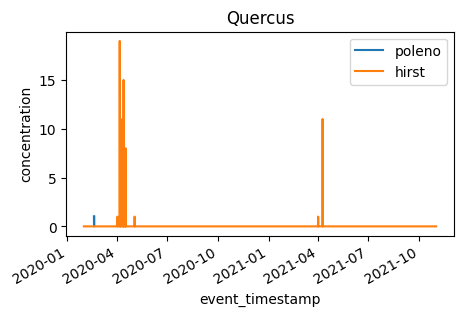

In [28]:
df_final_plot = df_poleno_to_plot.merge(df_hirst_to_plot, on='event_timestamp', how='outer')[['poleno', 'hirst']]
print(df_final_plot.corr())
fig = df_final_plot.plot(figsize=(5, 3), title=label_to_plot, ylabel='concentration')
fig.plot()
plt.show()

In [ ]:
df_final_plot.corr().poleno.hirst

In [ ]:
## 1.2 read hirst df
print('read hirst data...')
hirstfile = "hirst_pay_19022020-24052020.csv"
df_hirst = pd.DataFrame(pd.read_csv(hirstfile))
# create timestamp index
df_hirst['timestamp'] = df_hirst.apply(lambda x: datetime.datetime(x['Year'], x['Month'], x['Day'], x['Hour'], x['Minute']), axis=1)
# filter the data
df_hirst = df_hirst.set_index('timestamp')[[lbl for lbl in labels if lbl in df_hirst.columns]]
#df_hirst.columns = labels
df_hirst = df_hirst.replace(32767,np.nan)
df_hirst.head()

In [ ]:
## 3.3 resample hirst data
print('resample hirst...')
agg_time = pd.date_range(start=start_date, end=end_date, freq=agg_freq)
df_hirst_agg = pd.DataFrame(index=agg_time, columns=df_hirst.columns)

# need explanations:
for t in agg_time:
    tstr = t.strftime('%Y-%m-%d %H:%M:00')
    print(tstr)
    if pd.Timedelta(agg_freq) >= pd.Timedelta('1d'):
        tmp_bool = (df_hirst.index >= t) & (df_hirst.index < (t+pd.Timedelta(agg_freq)))
    else:
        tmp_bool = (df_hirst.index > (t-pd.Timedelta(agg_freq))) & (df_hirst.index <= t)
    
    for label in labels:
        df_hirst_agg.loc[tstr][label]=np.nanmean(df_hirst[tmp_bool][label])

if abc_switch:
    df_hirst_agg['abc'] = df_hirst_agg[['alnus','betula','corylus']].sum(axis=1)
# ---

labels = df_hirst_agg.columns
df_hirst_agg.to_csv(output_path+"hirst.csv")

### ==========================================
df_corr_all = pd.DataFrame(columns=labels)
df_corr_all['seuil']=np.nan
for seuil in seuils:
    ### 4. correlation ==============================
    print('computing correlations...')
    df_corr = pd.DataFrame(columns=labels, index=['hirst-p2','hirst-p4','hirst-p5','p2-p4','p2-p5','p4-p5','avg_hirst','avg_p2','avg_p4','avg_p5'])
    for label in labels:
        df_corr.loc['avg_hirst'][label] = df_hirst_agg[label].mean()
        if pswitch[0] == 1:
            df_corr.loc['hirst-p2'][label] = pd.concat([df_hirst_agg[label],df_p2_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
            df_corr.loc['avg_p2'][label] = df_p2_agg[label].mean()
        if pswitch[1] == 1:    
            df_corr.loc['hirst-p4'][label] = pd.concat([df_hirst_agg[label],df_p4_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
            df_corr.loc['avg_p4'][label] = df_p4_agg[label].mean()
        if pswitch[2] == 1:    
            df_corr.loc['hirst-p5'][label] = pd.concat([df_hirst_agg[label],df_p5_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
            df_corr.loc['avg_p5'][label] = df_p5_agg[label].mean()
        if pswitch[0] + pswitch[1] == 2:
            df_corr.loc['p2-p4'][label] = pd.concat([df_p2_agg[label],df_p4_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
        if pswitch[0] + pswitch[2] == 2:
            df_corr.loc['p2-p5'][label] = pd.concat([df_p2_agg[label],df_p5_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
        if pswitch[1] + pswitch[2] == 2:
            df_corr.loc['p4-p5'][label] = pd.concat([df_p4_agg[label],df_p5_agg[label]],axis=1).astype(float).corr().to_numpy()[0][1]
        
    #df_corr.to_csv(output_path+seuillabel+"_correlations.csv")
    df_corr['seuil']=seuil
    df_corr_all = pd.concat([df_corr_all,df_corr])

#### Old Prepare poleno data